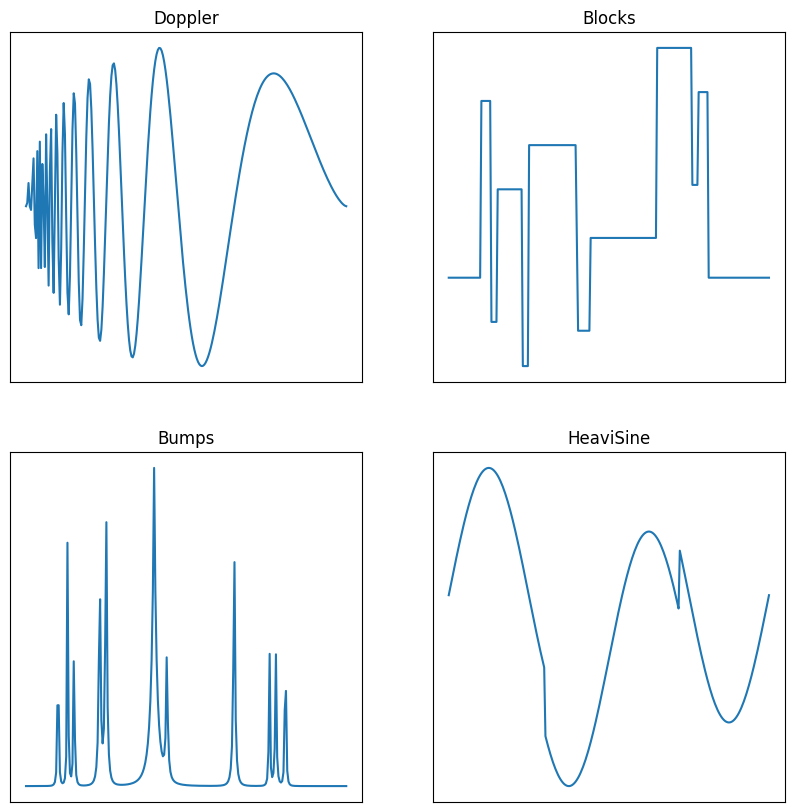

In [1]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)     


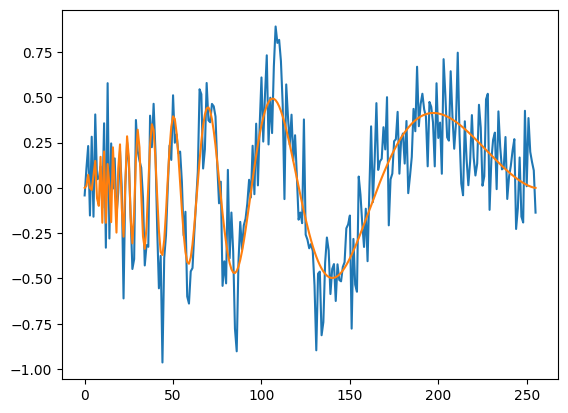

In [2]:

# Generate a sample signal
 
signal = doppler (x) + np.random.normal(0, 0.2,x.shape)
plt.plot(signal)
plt.plot(doppler (x))
# Perform wavelet decomposition
wavelet = 'db1'

coeffs  = pywt.wavedec(doppler (x), wavelet )
coeffs_noisy = pywt.wavedec(signal, wavelet )
 

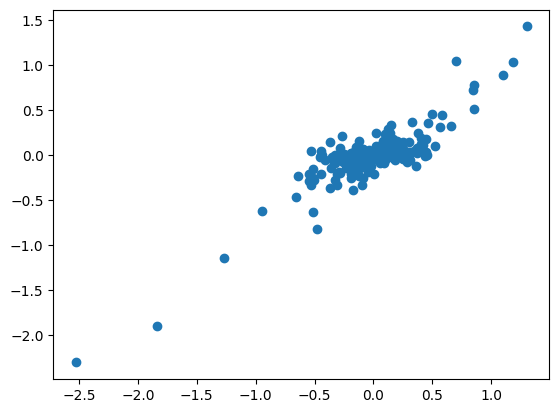

In [3]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
 

In [4]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py\ebnm_solver")
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *

In [5]:
res= ash(np.concatenate( coeffs_noisy), np.full_like(np.concatenate( coeffs_noisy) ,0.2 ))

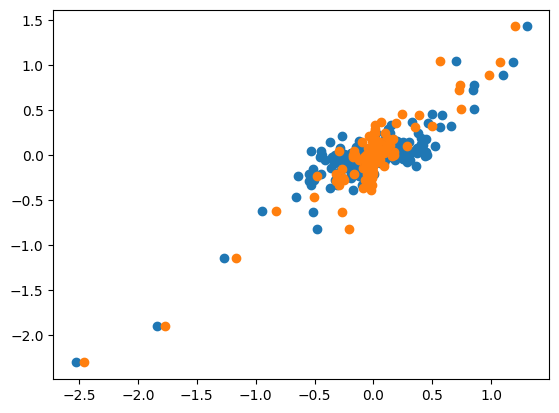

In [6]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
plt.scatter( res.post_mean , np.concatenate( coeffs ))

In [7]:
ncoeffs= coeffs
h=0
for  s in range(len(coeffs)):
    for l in range(coeffs[s].shape[0] ):
        ncoeffs[s][l] =res.post_mean[h]
        h=h+1

In [8]:
tt= pywt.waverec(ncoeffs, wavelet)

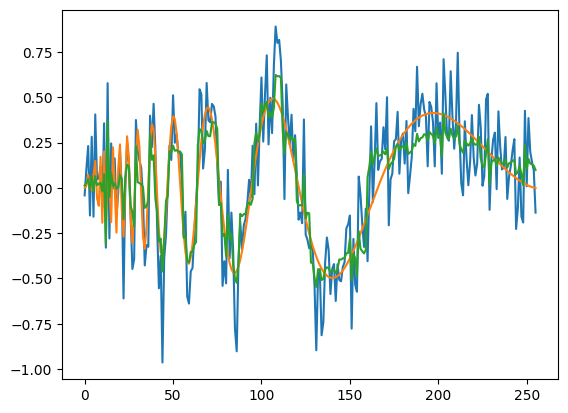

In [9]:
plt.plot(signal)
plt.plot(doppler (x))

plt.plot(tt)

In [10]:
def build_dyadic_wavelet_graph(coeffs, noise_level):
    """
    Build a dyadic graph from wavelet decomposition coefficients with noise levels.
    Each node at level n is connected to two nodes at level n+1.
    
    Parameters
    ----------
    coeffs : list of arrays
        Wavelet decomposition coefficients.
    noise_level : float
        Noise level to associate with each node.

    Returns
    -------
    Data : torch_geometric.data.Data
        PyTorch Geometric graph data object.
    node_labels : dict
        Dictionary mapping node indices to labels.
    node_levels : dict
        Dictionary mapping node indices to levels.
    node_coefficients : dict
        Dictionary mapping node indices to wavelet coefficients.
    """
    max_length = max(len(c) for c in coeffs)  # Determine max length of coefficient arrays
    node_features = []  # To store node features
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_feature = np.pad(coeffs[0], (0, max_length - len(coeffs[0])), mode='constant')
    root_feature = np.append(root_feature, noise_level)  # Append noise level to features
    node_features.append(root_feature.tolist())
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = coeffs[0][0]  # Use the first coefficient of the root

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    padded_feature = np.pad([c[coeff_index]],
                                            (0, max_length - 1), mode='constant')
                    padded_feature = np.append(padded_feature, noise_level)  # Append noise level
                    node_features.append(padded_feature.tolist())
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = c[coeff_index]  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert to PyTorch tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), node_labels, node_levels, node_coefficients


In [11]:

# Build the dyadic wavelet graph
wavelet_graph_noisy, node_labels_noisy, node_levels_noisy, node_coefficients_noisy = build_dyadic_wavelet_graph(coeffs_noisy, noise_level=0.2)


In [12]:
node_coefficients_noisy

{0: np.float64(0.8542294692499471),
 1: np.float64(-0.12242990278455967),
 2: np.float64(-0.9455164975943441),
 3: np.float64(-1.837498034770716),
 4: np.float64(0.5668320699770336),
 5: np.float64(-1.2692294467485907),
 6: np.float64(-2.5271848016022167),
 7: np.float64(0.7004729895170702),
 8: np.float64(0.2899453235597458),
 9: np.float64(-0.25974921694899017),
 10: np.float64(1.3036486559371254),
 11: np.float64(1.0974530874522315),
 12: np.float64(-0.5101903638690012),
 13: np.float64(-0.47756007733041916),
 14: np.float64(0.3775203076606426),
 15: np.float64(0.32491960429857003),
 16: np.float64(0.022147093430472997),
 17: np.float64(-0.1331371619247609),
 18: np.float64(0.655477369647471),
 19: np.float64(1.1845397443829924),
 20: np.float64(0.5873460812808464),
 21: np.float64(-0.6554680561522115),
 22: np.float64(-0.5311487084807001),
 23: np.float64(0.8459327510156002),
 24: np.float64(-0.26276127382768055),
 25: np.float64(-0.30507378910675353),
 26: np.float64(-0.1716341897

In [13]:
def build_dyadic_wavelet_graph(coeffs, noise_level):
    """
    Build a dyadic graph from wavelet decomposition coefficients with noise levels.
    Each node at level n is connected to two nodes at level n+1.
    
    Parameters
    ----------
    coeffs : list of arrays
        Wavelet decomposition coefficients.
    noise_level : float
        Noise level to associate with each node.

    Returns
    -------
    Data : torch_geometric.data.Data
        PyTorch Geometric graph data object.
    node_labels : dict
        Dictionary mapping node indices to labels.
    node_levels : dict
        Dictionary mapping node indices to levels.
    node_coefficients : dict
        Dictionary mapping node indices to wavelet coefficients.
    """
    node_features = []  # To store node features as (coefficient, noise_level)
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_coeff = coeffs[0][0]
    root_feature = (root_coeff, noise_level)  # Tuple with coefficient and noise level
    node_features.append(root_feature)
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = root_coeff

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    noisy_coeff = c[coeff_index]  # Coefficient value
                    node_feature = (noisy_coeff, noise_level)  # Tuple with coefficient and noise
                    node_features.append(node_feature)
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = noisy_coeff  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert node features to PyTorch tensors
    features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=features_tensor, edge_index=edge_index), node_labels, node_levels, node_coefficients
# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.show()

In [14]:
coeffs

[array([0.73887948]),
 array([-0.01113378]),
 array([-0.8310639 , -1.76877233]),
 array([ 0.35536554, -1.16646911, -2.46175706,  0.56465441]),
 array([ 0.04814809, -0.03753451,  1.20320405,  0.9858232 , -0.25961209,
        -0.2097218 ,  0.09844734,  0.06418017]),
 array([ 0.00176339, -0.0124125 ,  0.50113439,  1.07674031,  0.39072945,
        -0.50112041, -0.2941683 ,  0.73036959, -0.0384804 , -0.0545295 ,
        -0.01778846, -0.04880762, -0.00393228,  0.02324439,  0.00705417,
        -0.01469769]),
 array([-0.01501124,  0.0059639 ,  0.0120614 , -0.02165034, -0.26305282,
         0.03247144,  0.01486159, -0.01319934, -0.00819326,  0.74387298,
         0.28309424, -0.09188121, -0.25141454, -0.29193818,  0.0084541 ,
         0.00168904,  0.01334588,  0.00915969, -0.01957804, -0.02912922,
        -0.08717407,  0.08890678,  0.00789223, -0.08237062, -0.00239556,
        -0.00826483,  0.09919701, -0.00315047,  0.00227899,  0.01950316,
         0.07777644,  0.01040364]),
 array([-5.43562434

In [15]:
noise_level = 0.2  # Define the noise level
graph_data, node_labels, node_levels, node_coefficients = build_dyadic_wavelet_graph(coeffs, noise_level)
graph_data.x # View the node features


tensor([[ 7.3888e-01,  2.0000e-01],
        [-1.1134e-02,  2.0000e-01],
        [-8.3106e-01,  2.0000e-01],
        [-1.7688e+00,  2.0000e-01],
        [ 3.5537e-01,  2.0000e-01],
        [-1.1665e+00,  2.0000e-01],
        [-2.4618e+00,  2.0000e-01],
        [ 5.6465e-01,  2.0000e-01],
        [ 4.8148e-02,  2.0000e-01],
        [-3.7535e-02,  2.0000e-01],
        [ 1.2032e+00,  2.0000e-01],
        [ 9.8582e-01,  2.0000e-01],
        [-2.5961e-01,  2.0000e-01],
        [-2.0972e-01,  2.0000e-01],
        [ 9.8447e-02,  2.0000e-01],
        [ 6.4180e-02,  2.0000e-01],
        [ 1.7634e-03,  2.0000e-01],
        [-1.2412e-02,  2.0000e-01],
        [ 5.0113e-01,  2.0000e-01],
        [ 1.0767e+00,  2.0000e-01],
        [ 3.9073e-01,  2.0000e-01],
        [-5.0112e-01,  2.0000e-01],
        [-2.9417e-01,  2.0000e-01],
        [ 7.3037e-01,  2.0000e-01],
        [-3.8480e-02,  2.0000e-01],
        [-5.4530e-02,  2.0000e-01],
        [-1.7788e-02,  2.0000e-01],
        [-4.8808e-02,  2.000